In [7]:
import pandas as pd
import datetime
from simpledbf import Dbf5

In [8]:
########## INPUT ##############

In [9]:
# Unfaelle
unf_nrw_path= r"C:\Users\Simon\Analysen\Unfaelle\nrw\UNFAELLE_EPSG25832_Shape\UNFAELLE_point.dbf"

dbf = Dbf5(unf_nrw_path, codec='latin-1')
unf_nrw = dbf.to_dataframe()

#als datetime object
unf_nrw.UNFZEIT = pd.to_datetime(unf_nrw.UNFZEIT, format = '%Y%m%d%H%M%S')

#schneide min und sec ab
unf_nrw.UNFZEIT = unf_nrw.UNFZEIT.apply(lambda x: x.replace(minute=0, second=0) )

In [18]:
#Wetter Köln
temp_nrw_path = r"C:\Users\Simon\Analysen\Unfaelle\unfaelle_wetter\stundenwerte_TU_02667_hist\produkt_tu_stunde_19570901_20181231_02667.txt"

temp_nrw = pd.read_csv(temp_nrw_path, sep=";", low_memory=False)

#als datetime object
temp_nrw.MESS_DATUM = pd.to_datetime(temp_nrw.MESS_DATUM, format = '%Y%m%d%H')

# runde Temperatur
temp_nrw.TT_TU = temp_nrw.TT_TU.round(0)

# filtere auf das Jahr 2016 
temp_nrw = temp_nrw[(temp_nrw.MESS_DATUM>pd.Timestamp(datetime.date(2016,1,1))) & 
                         (temp_nrw.MESS_DATUM<pd.Timestamp(datetime.date(2017,1,1)))].copy() 

In [11]:
#BAB und Bstr NRW
#Quelle: #https://www.bast.de/BASt_2017/DE/Verkehrstechnik/Fachthemen/v2-verkehrszaehlung/Stundenwerte.html?nn=1817946

In [12]:
bast_path= r"C:\Users\Simon\Analysen\Bast_stundendaten\2016_a_b_NRW.csv"
bast= pd.read_csv(bast_path, sep=";", low_memory=False)

# time cleaner
bast.Stunde =bast.Stunde.replace(24,0)
                                 
bast['datetime']= "20" + bast.Datum.astype(str) + ("00" + bast.Stunde.astype(str)).str[-2:]

bast['datetime'] = pd.to_datetime(bast['datetime'], format = '%Y%m%d%H')

# sum counts
bast['KFZ_querschnitt']=bast.KFZ_R1 +bast.KFZ_R2

# anzahl der zaelstellen in nrw
len(bast.Zst.unique())

256

In [133]:
############## TIME FILTER   ###################

In [25]:
timerange= [6,22]

In [26]:
# time filter
bast = bast[(bast.datetime.dt.hour>=timerange[0]) & 
            (bast.datetime.dt.hour<=timerange[1])].copy()  

In [27]:
# time filter
temp_nrw = temp_nrw[(temp_nrw.MESS_DATUM.dt.hour>=timerange[0]) & 
                    (temp_nrw.MESS_DATUM.dt.hour<=timerange[1])].copy()  

In [28]:

# time filter
unf_nrw = unf_nrw[(unf_nrw.UNFZEIT.dt.hour>=timerange[0]) & 
                  (unf_nrw.UNFZEIT.dt.hour<=timerange[1])].copy()  

In [ ]:
##################### MERGES - > Häufigkeiten #########################

In [78]:
##### UNFALL und TEMPERATUR

In [19]:
nrw_merge = unf_nrw.merge(temp_nrw[['MESS_DATUM','TT_TU']], how='left', left_on='UNFZEIT', right_on='MESS_DATUM')

In [20]:
# haefigkeit unfealle nach temp
nrw_merge.TT_TU.value_counts().head()

4.0     1731
8.0     1695
6.0     1526
16.0    1384
7.0     1373
Name: TT_TU, dtype: int64

In [21]:
nrw_merge_2016_hist = nrw_merge.TT_TU.value_counts().reset_index()
nrw_merge_2016_hist = nrw_merge_2016_hist.rename(columns={'index': 'temp', 'TT_TU': 'count'})

In [22]:
nrw_merge_2016_hist['rel']= nrw_merge_2016_hist['count']/nrw_merge_2016_hist['count'].sum()

In [88]:
nrw_merge_2016_hist['label']=nrw_merge_2016_hist['count']

In [42]:
##### Stunden und TEMPERATUR

In [43]:
temp_nrw.TT_TU.value_counts().head()

6.0     359
8.0     355
4.0     346
7.0     315
12.0    267
Name: TT_TU, dtype: int64

In [46]:
temp_nrw_hist = temp_nrw.TT_TU.value_counts().reset_index()
temp_nrw_hist = temp_nrw_hist.rename(columns={'index': 'temp', 'TT_TU': 'count'})

In [47]:
temp_nrw_hist['rel']= temp_nrw_hist['count']/temp_nrw_hist['count'].sum()

In [87]:
temp_nrw_hist['label']=temp_nrw_hist['count']


In [49]:
##### BAST und TEMPERATUR
nrw_merge_kfz_temp = bast.merge(temp_nrw[['MESS_DATUM','TT_TU']], how='left', left_on='datetime', right_on='MESS_DATUM')

In [50]:
### group by count and temp
nrw_merge_kfz_temp_hist = nrw_merge_kfz_temp.groupby('TT_TU')['KFZ_querschnitt'].agg(['size', 'mean'])

In [51]:
nrw_merge_kfz_temp_hist =nrw_merge_kfz_temp_hist.reset_index()

nrw_merge_kfz_temp_hist = nrw_merge_kfz_temp_hist.rename(columns={'mean': 'count', 'TT_TU': 'temp'})

In [52]:
nrw_merge_kfz_temp_hist.head()

,temp,size,count
0,-8.0,1024,2350.982422
1,-7.0,1280,1703.121094
2,-6.0,3840,2186.040104
3,-5.0,2048,1956.430664
4,-4.0,6144,2037.200846


In [53]:
nrw_merge_kfz_temp_hist['rel']= (nrw_merge_kfz_temp_hist['count']*nrw_merge_kfz_temp_hist['size'])/(nrw_merge_kfz_temp_hist['count']*nrw_merge_kfz_temp_hist['size']).sum()

In [89]:
nrw_merge_kfz_temp_hist['label']= (nrw_merge_kfz_temp_hist['count']*nrw_merge_kfz_temp_hist['size'])

In [54]:
nrw_merge_kfz_temp_hist.head()

,temp,size,count,rel
0,-8.0,1024,2350.982422,0.000605
1,-7.0,1280,1703.121094,0.000548
2,-6.0,3840,2186.040104,0.002110
3,-5.0,2048,1956.430664,0.001007
4,-4.0,6144,2037.200846,0.003146


In [39]:
################  APPEND MERGED   ###################

In [56]:
temp_nrw_hist['cat']='#Stunden'

In [57]:
nrw_merge_2016_hist['cat']='#Unfälle'

In [58]:
nrw_merge_kfz_temp_hist['cat']='Verkehrsaufkommen'

In [90]:
both =temp_nrw_hist.append(nrw_merge_2016_hist)

In [91]:
all3 =nrw_merge_kfz_temp_hist.append(both)

C:\Users\Simon\Anaconda3\envs\geo_p\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [92]:
all3

,cat,count,label,rel,size,temp
0,Verkehrsaufkommen,2350.982422,2407406.0,0.000605,1024,-8.0
1,Verkehrsaufkommen,1703.121094,2179995.0,0.000548,1280,-7.0
2,Verkehrsaufkommen,2186.040104,8394394.0,0.002110,3840,-6.0
3,Verkehrsaufkommen,1956.430664,4006770.0,0.001007,2048,-5.0
4,Verkehrsaufkommen,2037.200846,12516562.0,0.003146,6144,-4.0
5,Verkehrsaufkommen,2222.181332,21617380.0,0.005434,9728,-3.0
6,Verkehrsaufkommen,2017.392940,27888440.0,0.007010,13824,-2.0
7,Verkehrsaufkommen,2097.424971,28457862.0,0.007154,13568,-1.0
8,Verkehrsaufkommen,2134.680240,54101336.0,0.013600,25344,0.0
9,Verkehrsaufkommen,2321.572206,58837926.0,0.014790,25344,1.0


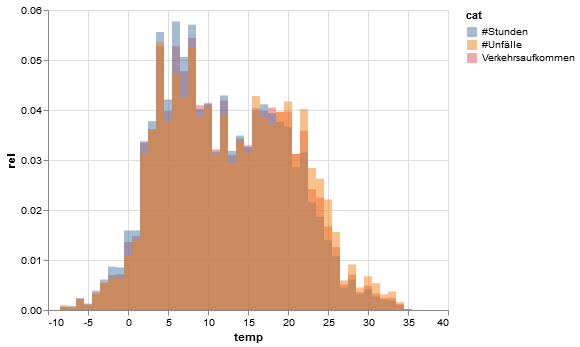

In [65]:
import altair as alt
alt.renderers.enable('notebook')



chart2= alt.Chart(all3).mark_bar(opacity=0.5,size=8).encode(
    x='temp',
    y=alt.Y('rel', stack=None),
    color='cat'   
)

chart2

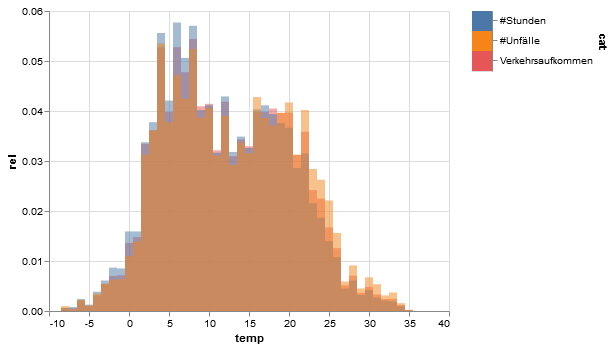

In [80]:
import altair as alt

selection = alt.selection_multi(fields=['cat'])
color = alt.condition(selection, alt.Color('cat:N', legend=None), alt.value('transparent'))


chart= alt.Chart(all3).mark_bar(opacity=0.5,size=8).encode(
    x='temp',
    y=alt.Y('rel', stack=None), 
    color=color
).add_selection(
    selection
)

legend = alt.Chart(all3).mark_rect().encode(
    y=alt.Y('cat:N', axis=alt.Axis(orient='right')),
    color=color
).add_selection(
    selection
)

chart | legend

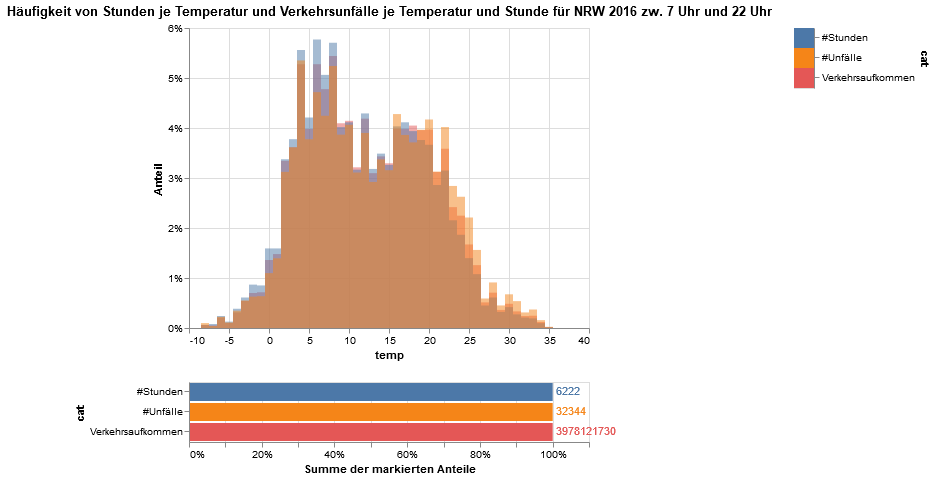

In [104]:
import altair as alt


selection = alt.selection_multi(fields=['cat'])
color = alt.condition(selection, alt.Color('cat:N', legend=None), alt.value('transparent'))






brush = alt.selection(type='interval', encodings=["x"])

title='Häufigkeit von Stunden je Temperatur und Verkehrsunfälle je Temperatur und Stunde für NRW 2016 zw. 7 Uhr und 22 Uhr'


chart= alt.Chart(all3,title=title).mark_bar(opacity=0.5,size=8).encode(
    x='temp',
    y= alt.Y('rel', axis=alt.Axis(format='%', title='Anteil')),#,alt.Y('rel', stack=None), 
    color=color,
    #tooltip='label'
).add_selection(
    brush
).add_selection(
    selection
)

legend = alt.Chart(all3).mark_rect().encode(
    y=alt.Y('cat:N', axis=alt.Axis(orient='right')),
    color=color
).add_selection(
    selection
)




bars = alt.Chart(all3).mark_bar().encode(
    y='cat:N',
    color=color,
    x=alt.X('sum(rel):Q', axis=alt.Axis(format='%', title='Summe der markierten Anteile')) #'sum(rel):Q' 
).transform_filter(
    brush
)

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='sum(label):N'
    #text= alt.condition(alt.datum.cat==alt.value('Verkehrsaufkommen'), 'sum(size):N', 'sum(count):N')
)



chrt= (chart  & (bars + text)) | legend

chrt

In [108]:
chrt.save('unfl_temp_nrw.html')

In [106]:
from bs4 import BeautifulSoup
html = open("unfl_temp.html").read()
soup = BeautifulSoup(html)

sources = ['https://www.bast.de/BASt_2017/DE/Verkehrstechnik/Fachthemen/v2-verkehrszaehlung/Stundenwerte.html?nn=1817946',
           'blabla',
           'https://www.dwd.de/DE/leistungen/klimadatendeutschland/klarchivstunden.html'
    
]

for i in sources:
    new_div = soup.new_tag('div')
    new_div.string=i
    soup.html.append(new_div)

with open("unfl_temp_bs4.html", "w") as file:
    file.write(str(soup))

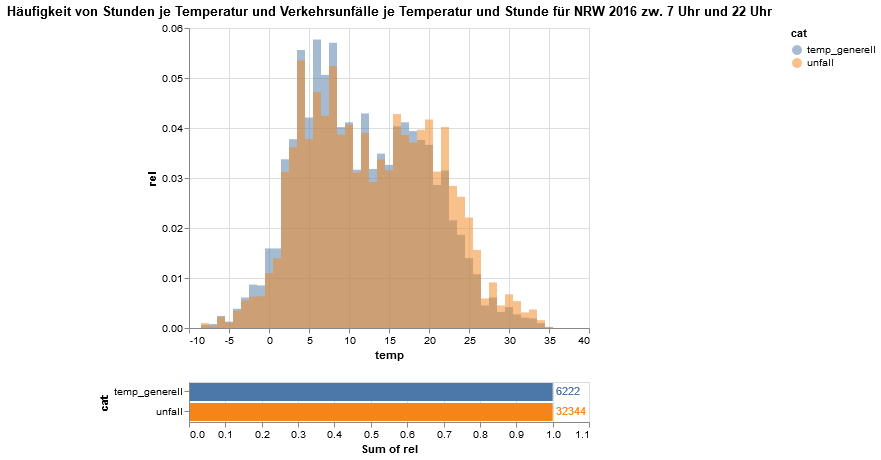

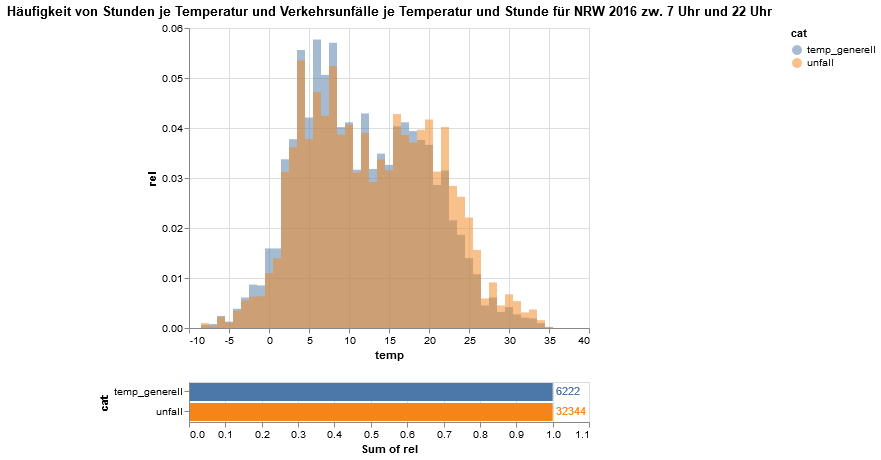

In [246]:
import altair as alt


brush = alt.selection(type='interval', encodings=["x"])

title='Häufigkeit von Stunden je Temperatur und Verkehrsunfälle je Temperatur und Stunde für NRW 2016 zw. 7 Uhr und 22 Uhr'

chart2= alt.Chart(both,title=title).mark_bar(opacity=0.5,size=8).encode(
    x='temp',
    y=alt.Y('rel', stack=None),
    color=alt.condition(brush, 'cat:N', alt.value('lightgray')) 
).add_selection(
    brush
)



bars = alt.Chart(both).mark_bar().encode(
    y='cat:N',
    color='cat:N',
    x='sum(rel):Q'
).transform_filter(
    brush
)

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='sum(count):N'
)




chrt= chart2 & (bars + text) 

chrt

In [114]:
chrt.save('unfl_temp.html')

In [128]:
from bs4 import BeautifulSoup
html = open("unfl_temp.html").read()
soup = BeautifulSoup(html)
new_div = soup.new_tag('div')
new_div.string="abcdef"
soup.html.append(new_div)

with open("unfl_temp_bs4.html", "w") as file:
    file.write(str(soup))

In [ ]:
################# BAST ###################

In [ ]:
#https://www.bast.de/BASt_2017/DE/Verkehrstechnik/Fachthemen/v2-verkehrszaehlung/Stundenwerte.html?nn=1817946

In [133]:
bast_path= r"C:\Users\Simon\Analysen\Bast_stundendaten\2016_a_b_NRW.csv"

In [134]:
bast= pd.read_csv(bast_path, sep=";", low_memory=False)

In [131]:
bast.head()

,TKNR,Zst,Land,Strklas,Strnum,Datum,Wotag,Fahrtzw,Stunde,KFZ_R1,...,Bus_R2,K_Bus_R2,LoA_R2,K_LoA_R2,Lzg_R2,K_Lzg_R2,Sat_R2,K_Sat_R2,Son_R2,K_Son_R2
0,5308,5013,5,A,565,160101,5,s,1,90,...,0,-,1,-,0,-,0,-,0,-
1,5308,5013,5,A,565,160101,5,s,2,231,...,0,-,1,-,1,-,1,-,0,-
2,5308,5013,5,A,565,160101,5,s,3,223,...,0,-,1,-,0,-,0,-,0,-
3,5308,5013,5,A,565,160101,5,s,4,134,...,0,-,1,-,1,-,1,-,0,-
4,5308,5013,5,A,565,160101,5,s,5,68,...,0,-,1,-,1,-,0,-,0,-


In [152]:
bast_tester=bast[:10].copy()

In [172]:
bast.Stunde =bast.Stunde.replace(24,0)

In [173]:
bast['datetime']= "20" + bast.Datum.astype(str) + ("00" + bast.Stunde.astype(str)).str[-2:]


In [175]:
bast['datetime'] = pd.to_datetime(bast['datetime'], format = '%Y%m%d%H')

In [176]:
# time filter
bast = bast[(bast.datetime.dt.hour>=6) & 
            (bast.datetime.dt.hour<=22)].copy()  

In [181]:
bast['KFZ_querschnitt']=bast.KFZ_R1 +bast.KFZ_R2

In [188]:
#pd.set_option('display.max_columns', 15)

In [186]:
# anzahl der zaelstellen in nrw
len(bast.Zst.unique())

256

In [206]:
nrw_merge_kfz_temp = bast.merge(temp_nrw[['MESS_DATUM','TT_TU']], how='left', left_on='datetime', right_on='MESS_DATUM')

In [207]:
nrw_merge_kfz_temp.head()

,TKNR,Zst,Land,Strklas,Strnum,Datum,Wotag,...,K_Sat_R2,Son_R2,K_Son_R2,datetime,KFZ_querschnitt,MESS_DATUM,TT_TU
0,5308,5013,5,A,565,160101,5,...,-,0,-,2016-01-01 06:00:00,179,2016-01-01 06:00:00,3.7
1,5308,5013,5,A,565,160101,5,...,-,0,-,2016-01-01 07:00:00,141,2016-01-01 07:00:00,3.7
2,5308,5013,5,A,565,160101,5,...,-,0,-,2016-01-01 08:00:00,141,2016-01-01 08:00:00,3.9
3,5308,5013,5,A,565,160101,5,...,-,0,-,2016-01-01 09:00:00,150,2016-01-01 09:00:00,4.6
4,5308,5013,5,A,565,160101,5,...,-,0,-,2016-01-01 10:00:00,234,2016-01-01 10:00:00,5.5


In [208]:
nrw_merge_kfz_temp.TT_TU = nrw_merge_kfz_temp.TT_TU.round(0)

In [ ]:
### group by count and temp

In [216]:
#nrw_merge_kfz_temp.groupby(['TT_TU'])['KFZ_querschnitt'].mean()

In [238]:
nrw_merge_kfz_temp_hist = nrw_merge_kfz_temp.groupby('TT_TU')['KFZ_querschnitt'].agg(['size', 'mean'])

In [239]:
nrw_merge_kfz_temp_hist =nrw_merge_kfz_temp_hist.reset_index()

nrw_merge_kfz_temp_hist = nrw_merge_kfz_temp_hist.rename(columns={'mean': 'count', 'TT_TU': 'temp'})

In [240]:
nrw_merge_kfz_temp_hist

,temp,size,count
0,-8.0,1024,2350.982422
1,-7.0,1280,1703.121094
2,-6.0,3840,2186.040104
3,-5.0,2048,1956.430664
4,-4.0,6144,2037.200846
5,-3.0,9728,2222.181332
6,-2.0,13824,2017.392940
7,-1.0,13568,2097.424971
8,0.0,25344,2134.680240
9,1.0,25344,2321.572206


In [261]:
nrw_merge_kfz_temp_hist['rel']= (nrw_merge_kfz_temp_hist['count']*nrw_merge_kfz_temp_hist['size'])/(nrw_merge_kfz_temp_hist['count']*nrw_merge_kfz_temp_hist['size']).sum()

In [262]:
nrw_merge_kfz_temp_hist

,temp,size,count,rel,cat
0,-8.0,1024,2350.982422,0.000605,zaehlungen
1,-7.0,1280,1703.121094,0.000548,zaehlungen
2,-6.0,3840,2186.040104,0.002110,zaehlungen
3,-5.0,2048,1956.430664,0.001007,zaehlungen
4,-4.0,6144,2037.200846,0.003146,zaehlungen
5,-3.0,9728,2222.181332,0.005434,zaehlungen
6,-2.0,13824,2017.392940,0.007010,zaehlungen
7,-1.0,13568,2097.424971,0.007154,zaehlungen
8,0.0,25344,2134.680240,0.013600,zaehlungen
9,1.0,25344,2321.572206,0.014790,zaehlungen


In [303]:

nrw_merge_kfz_temp_hist['cat']='Verkehrsaufkommen'

In [304]:
all3 =nrw_merge_kfz_temp_hist.append(both)

In [305]:
all3.cat.unique()

array(['Verkehrsaufkommen', '#Stunden', '#Unfälle'], dtype=object)

In [306]:
all3

,cat,count,rel,size,temp
0,Verkehrsaufkommen,2350.982422,0.000605,1024,-8.0
1,Verkehrsaufkommen,1703.121094,0.000548,1280,-7.0
2,Verkehrsaufkommen,2186.040104,0.002110,3840,-6.0
3,Verkehrsaufkommen,1956.430664,0.001007,2048,-5.0
4,Verkehrsaufkommen,2037.200846,0.003146,6144,-4.0
5,Verkehrsaufkommen,2222.181332,0.005434,9728,-3.0
6,Verkehrsaufkommen,2017.392940,0.007010,13824,-2.0
7,Verkehrsaufkommen,2097.424971,0.007154,13568,-1.0
8,Verkehrsaufkommen,2134.680240,0.013600,25344,0.0
9,Verkehrsaufkommen,2321.572206,0.014790,25344,1.0


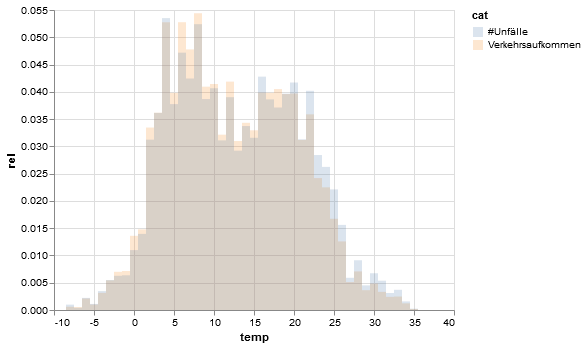

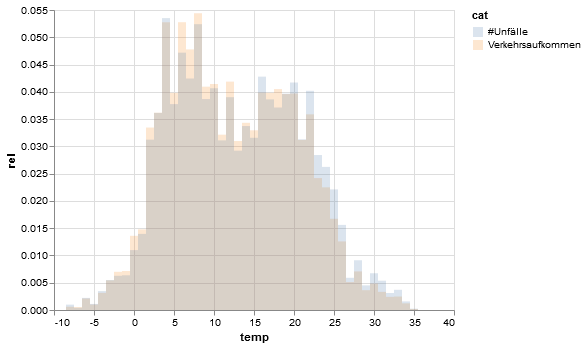

In [282]:
import altair as alt
alt.renderers.enable('notebook')



chart2= alt.Chart(all3[(all3.cat=='#Unfälle') | (all3.cat=='Verkehrsaufkommen')]).mark_bar(opacity=0.2,size=8).encode(
    x='temp',
    y=alt.Y('rel', stack=None),
    color='cat'   
)

chart2

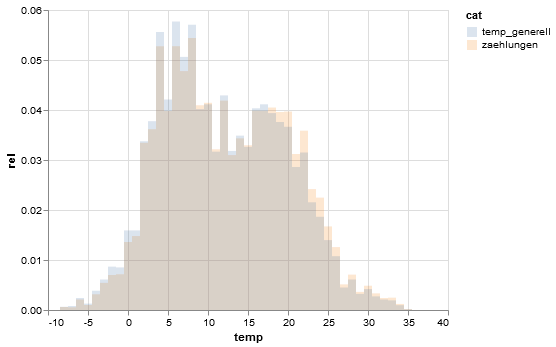

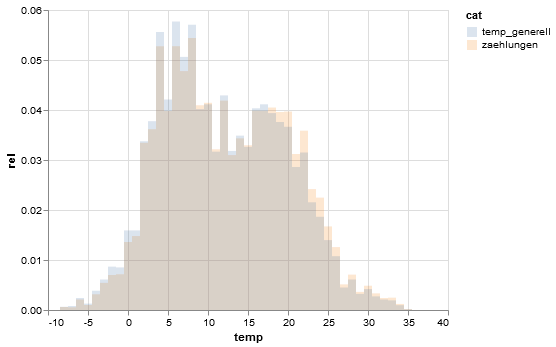

In [268]:
import altair as alt
alt.renderers.enable('notebook')



chart2= alt.Chart(all3[(all3.cat=='temp_generell') | (all3.cat=='zaehlungen')]).mark_bar(opacity=0.2,size=8).encode(
    x='temp',
    y=alt.Y('rel', stack=None),
    color='cat'   
)

chart2

In [307]:
all3

,cat,count,rel,size,temp
0,Verkehrsaufkommen,2350.982422,0.000605,1024,-8.0
1,Verkehrsaufkommen,1703.121094,0.000548,1280,-7.0
2,Verkehrsaufkommen,2186.040104,0.002110,3840,-6.0
3,Verkehrsaufkommen,1956.430664,0.001007,2048,-5.0
4,Verkehrsaufkommen,2037.200846,0.003146,6144,-4.0
5,Verkehrsaufkommen,2222.181332,0.005434,9728,-3.0
6,Verkehrsaufkommen,2017.392940,0.007010,13824,-2.0
7,Verkehrsaufkommen,2097.424971,0.007154,13568,-1.0
8,Verkehrsaufkommen,2134.680240,0.013600,25344,0.0
9,Verkehrsaufkommen,2321.572206,0.014790,25344,1.0


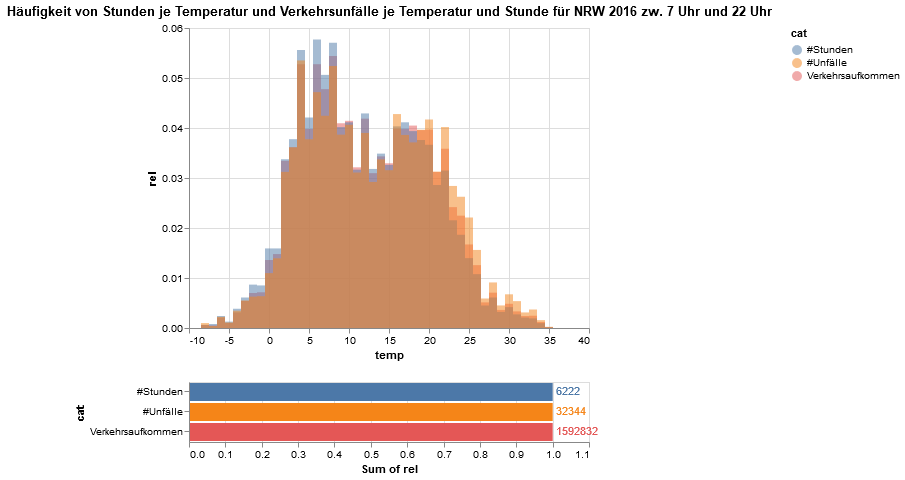

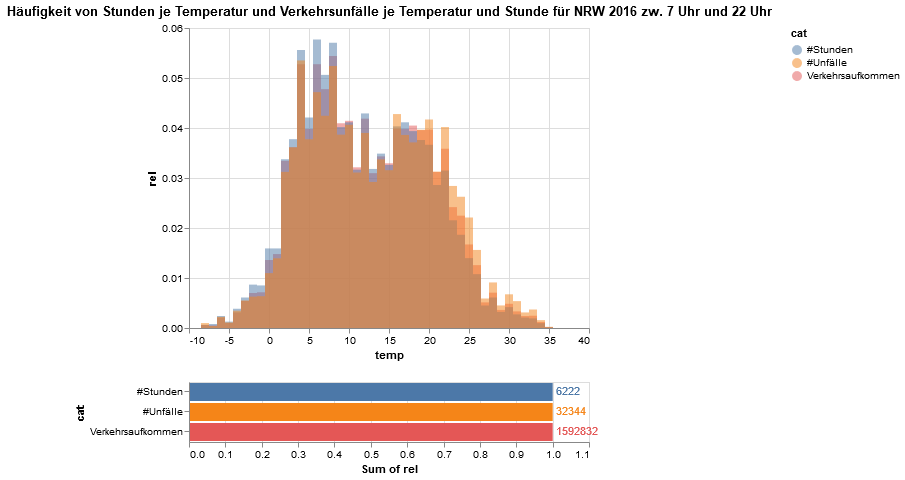

In [311]:
import altair as alt


brush = alt.selection(type='interval', encodings=["x"])

title='Häufigkeit von Stunden je Temperatur und Verkehrsunfälle je Temperatur und Stunde für NRW 2016 zw. 7 Uhr und 22 Uhr'

chart2= alt.Chart(all3,title=title).mark_bar(opacity=0.5,size=8).encode(
    x='temp',
    y=alt.Y('rel', stack=None),
    color=alt.condition(brush, 'cat:N', alt.value('lightgray')) 
).add_selection(
    brush
)



bars = alt.Chart(all3).mark_bar().encode(
    y='cat:N',
    color='cat:N',
    x='sum(rel):Q'
).transform_filter(
    brush
)

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='sum(size):N'
    #text= alt.condition(alt.datum.cat==alt.value('Verkehrsaufkommen'), 'sum(size):N', 'sum(count):N')
)

#    color=alt.condition(
 #       alt.datum.xval < selector.cutoff,
  #      alt.value('red'), alt.value('blue')
   # )


chrt= chart2 & (bars + text) 

chrt